# Dreamer Diary analysis

Main objective: Analyzing certain dreamers diaries by visualizing how the sentiment scores change over time. 

In [46]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
import regex as re

In [47]:
# using VADER to get polarity scores now 
! pip install vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
obj = SentimentIntensityAnalyzer()

> Main dataset

In [48]:
# main df
df = pd.read_csv("data/person_details.csv")
df.head(10)

,Unnamed: 0,id,diary_ref,person,description,sex,sex_code,year,entry_count
0,0,1,diary01.csv,alta: a detailed dreamer,Alta is an adult woman who wrote down her drea...,female,1,1985-1997,422
1,1,2,diary02.csv,angie: age 18 & 20,Angie is a college student whose dreams are of...,female,1,1996,48
2,2,3,diary03.csv,arlie: a middle-aged woman,Arlie is an older adult woman who wrote down h...,female,1,1992-1998,212
3,3,4,diary04.csv,barb sanders,Barb Sanders (not her real name) is a middle-a...,female,1,1960-1997,3116
4,4,5,diary05.csv,barb sanders #2,"1138 more dreams from Barb Sanders, written do...",female,1,1997-2001,1138
5,5,6,diary06.csv,barb sanders: baseline,These 250 dreams are a representative sample o...,female,1,1960-1997,250
6,6,7,diary07.csv,bay area girls: grades 4-6,The 388 dreams in this set were collected in N...,female,1,1996-1997,234
7,7,8,diary08.csv,bay area girls: grades 7-9,The 388 dreams in this set were collected in N...,female,1,1996-1997,154
8,8,9,diary09.csv,bea 1: a high school student,Bea's vivid dream reports from age 14 to 16 pr...,female,1,2003-2005,223
9,9,10,diary10.csv,bea 2: a college student,See Bea 1.,female,1,2007-2010,63


In [49]:
df.shape

(94, 9)

## Diary 1: Atla

- Atla is a detailed dreamer
- She has 422 diary entries

In [50]:
diary1_df = pd.read_csv("data/diaries/diary01.csv", sep = "|")
diary1_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#1 (1957),"The one at the Meads's house, where it's bigge...",0.010,0.948,0.041,0.6486
1,1,#2 (8/11/67),I'm at a family reunion in a large fine house ...,0.041,0.906,0.053,-0.1941
2,2,#3 (8/1/85),I watch a plane fly past and shortly realize i...,0.076,0.856,0.069,-0.1573
3,3,#4 (1985?),Me pulling the green leaves and berries off so...,0.098,0.829,0.073,-0.9523
4,4,#5 (1985?),I'm in a room that reminds me of (but definite...,0.040,0.889,0.071,0.9639


#### Diary 1 data cleaning

> removing NaNs

In [10]:
# replace empty spaces with NaN
diary1_df.replace('', np.nan, inplace=True)

# remove rows with NaN values
diary1_df = diary1_df.dropna()
diary1_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#1 (1957),"The one at the Meads's house, where it's bigge...",0.010,0.948,0.041,0.6486
1,1,#2 (8/11/67),I'm at a family reunion in a large fine house ...,0.041,0.906,0.053,-0.1941
2,2,#3 (8/1/85),I watch a plane fly past and shortly realize i...,0.076,0.856,0.069,-0.1573
3,3,#4 (1985?),Me pulling the green leaves and berries off so...,0.098,0.829,0.073,-0.9523
4,4,#5 (1985?),I'm in a room that reminds me of (but definite...,0.040,0.889,0.071,0.9639


> cleaning 'raw_number' column

In [11]:
# converting the 'raw_numbers' column into a column with just years
def conv_to_year(raw_years):
    # removes all ids
    date_uncleaned = raw_years.split()[1]
    # removing (), ?, (*) from the years text
    date = re.sub('\(|\)|\*|\?', '', date_uncleaned)
    
    # if it's just one year 
    if "/" not in date: 
        return date
    else:
        full_year = "19" + date.split("/")[2]
        return full_year[:4] #in case there were typos

diary1_df = diary1_df.assign(year = diary1_df['raw_number'].apply(conv_to_year))
# unique_values = diary1_df['year'].unique()
# print(unique_values)

# now after cleaning, replace empty spaces with NaN
diary1_df.replace('', np.nan, inplace=True)
# remove rows with NaN values
diary1_df = diary1_df.dropna()
# convert years column from string type to int type
diary1_df['year'] = diary1_df['year'].astype(int)
diary1_df

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,year
0,0,#1 (1957),"The one at the Meads's house, where it's bigge...",0.010,0.948,0.041,0.6486,1957
1,1,#2 (8/11/67),I'm at a family reunion in a large fine house ...,0.041,0.906,0.053,-0.1941,1967
2,2,#3 (8/1/85),I watch a plane fly past and shortly realize i...,0.076,0.856,0.069,-0.1573,1985
3,3,#4 (1985?),Me pulling the green leaves and berries off so...,0.098,0.829,0.073,-0.9523,1985
4,4,#5 (1985?),I'm in a room that reminds me of (but definite...,0.040,0.889,0.071,0.9639,1985
...,...,...,...,...,...,...,...,...
417,417,#415 (7/4/96),"I'm on a little trip out of town, trying to ge...",0.030,0.936,0.034,0.2508,1996
418,418,#416 (7/8/96),I'm looking for a place to live in another tow...,0.022,0.840,0.138,0.9885,1996
419,419,#417 (11/12/97),"I'm in another city. It's very different, old,...",0.043,0.844,0.113,0.9866,1997
420,420,#418 (11/23/97),Dana Scully is pushing a shopping cart up to a...,0.064,0.891,0.045,-0.7947,1997


> Analyzing sentiment scores over the years 

In [12]:
# get average postiive and negative scores for each year 
diary1_scores = diary1_df[['year', 'negative', 'neutral', 'positive', 'compound']]
diary1_scores = diary1_scores.groupby('year').mean()
diary1_scores

,negative,neutral,positive,compound
year,,,,
1957,0.010000,0.948000,0.041000,0.648600
1967,0.041000,0.906000,0.053000,-0.194100
1985,0.061000,0.857333,0.081750,0.145483
1986,0.051711,0.871508,0.076898,0.331026
1987,0.050864,0.868106,0.081076,0.457174
1988,0.047417,0.877139,0.075222,0.436989
1989,0.039565,0.879043,0.081522,0.668052
1990,0.048902,0.876537,0.074585,0.440098
1991,0.055942,0.865615,0.078327,0.397306


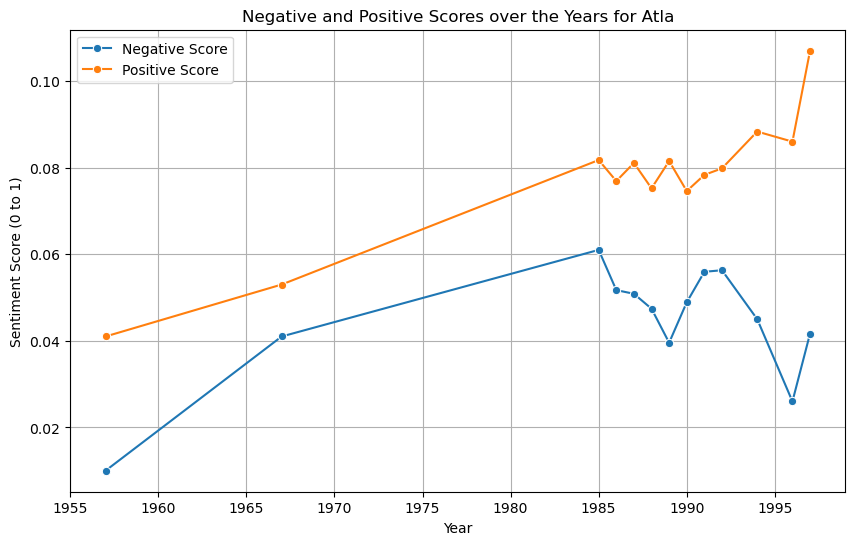

In [13]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='year', y='negative', data=diary1_scores, label='Negative Score', marker='o')
sns.lineplot(x='year', y='positive', data=diary1_scores, label='Positive Score', marker='o')

plt.title('Negative and Positive Scores over the Years for Atla')
plt.xlabel('Year')
plt.ylabel('Sentiment Score (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

## Diary 92: War Veteran 

Diary 92 contains diaries from a vietnam war veteran after the war. The Vietnam War was from 1955-1975. These diaries were taken from 2016-2017.

In [15]:
# df for this analysis
veteran_df = pd.read_csv("data/diaries/diary92.csv", sep = "|")
veteran_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#0001 (2016-09-05),I'm in Honduras at some kind of border crossin...,0.192,0.780,0.028,-0.9442
1,1,#0002 (2016-09-06),I'm talking with a young Hispanic man. He's so...,0.000,0.702,0.298,0.9403
2,2,#0003 (2016-09-08),I'm part of a bomber crew flying over a Europe...,0.043,0.916,0.041,0.4879
3,3,#0004 (2016-09-08),I'm with my friend Joan outside a large church...,0.076,0.845,0.078,0.3182
4,4,#0005 (2016-09-10),I'm living with roommates in the basement of a...,0.146,0.796,0.058,-0.9490


### Diary 92 data cleaning

> cleaning 'raw_numbers' column

In [16]:
# converting the 'raw_numbers' column into a column with just years
def conv_to_year92(raw_date):
    date_str = raw_date[7:-1]
    # convert to datetime format
    date_datetime = pd.to_datetime(date_str)
    return date_datetime

veteran_df = veteran_df.assign(date = veteran_df['raw_number'].apply(conv_to_year92))
# checking unique values --> checks work
# unique_values = veteran_df['year'].unique()
# print(unique_values)

# # now after cleaning, replace empty spaces with NaN
veteran_df.replace('', np.nan, inplace=True)
# remove rows with NaN values
veteran_df = veteran_df.dropna()
veteran_df

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,date
0,0,#0001 (2016-09-05),I'm in Honduras at some kind of border crossin...,0.192,0.780,0.028,-0.9442,2016-09-05
1,1,#0002 (2016-09-06),I'm talking with a young Hispanic man. He's so...,0.000,0.702,0.298,0.9403,2016-09-06
2,2,#0003 (2016-09-08),I'm part of a bomber crew flying over a Europe...,0.043,0.916,0.041,0.4879,2016-09-08
3,3,#0004 (2016-09-08),I'm with my friend Joan outside a large church...,0.076,0.845,0.078,0.3182,2016-09-08
4,4,#0005 (2016-09-10),I'm living with roommates in the basement of a...,0.146,0.796,0.058,-0.9490,2016-09-10
...,...,...,...,...,...,...,...,...
458,458,#0459 (2017-09-01),In a town like the town I lived in from 2001 t...,0.098,0.875,0.026,-0.8360,2017-09-01
459,459,#0460 (2017-09-03),"At night, as people leave, I'm standing in a f...",0.082,0.878,0.040,-0.7430,2017-09-03
460,460,#0461 (2017-09-04),"I'm in an airplane flying high over the earth,...",0.064,0.914,0.022,-0.5719,2017-09-04
461,461,#0462 (2017-09-05),"As an adult, I'm living at home with brother a...",0.080,0.879,0.041,-0.6580,2017-09-05


> 2016 visualization

In [17]:
# filtering data for the year 2016
veteran_df_2016 = veteran_df[veteran_df['date'].dt.year == 2016]
# addings months
veteran_df_2016 = veteran_df_2016.assign(month = veteran_df_2016['date'].dt.month)
veteran_df_2016.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,date,month
0,0,#0001 (2016-09-05),I'm in Honduras at some kind of border crossin...,0.192,0.780,0.028,-0.9442,2016-09-05,9
1,1,#0002 (2016-09-06),I'm talking with a young Hispanic man. He's so...,0.000,0.702,0.298,0.9403,2016-09-06,9
2,2,#0003 (2016-09-08),I'm part of a bomber crew flying over a Europe...,0.043,0.916,0.041,0.4879,2016-09-08,9
3,3,#0004 (2016-09-08),I'm with my friend Joan outside a large church...,0.076,0.845,0.078,0.3182,2016-09-08,9
4,4,#0005 (2016-09-10),I'm living with roommates in the basement of a...,0.146,0.796,0.058,-0.9490,2016-09-10,9


In [18]:
veteran_2016_avg = veteran_df_2016[['month', 'negative', 'neutral', 'positive', 'compound']].groupby('month').mean()
veteran_2016_avg

,negative,neutral,positive,compound
month,,,,
9,0.071350,0.843700,0.084925,0.113630
10,0.069836,0.847309,0.082855,0.087129
11,0.062667,0.858143,0.079143,0.069879
12,0.062143,0.863571,0.074229,0.104511


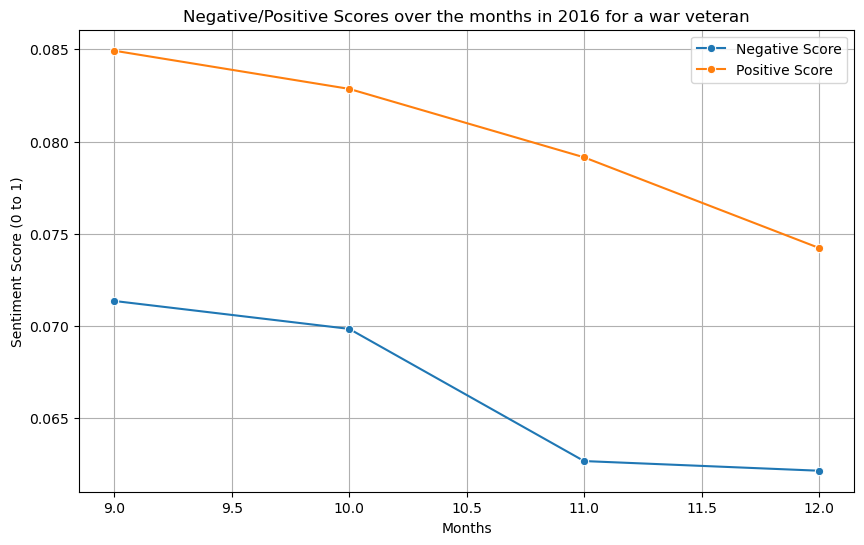

In [19]:
# plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='month', y='negative', data=veteran_2016_avg, label='Negative Score', marker='o')
sns.lineplot(x='month', y='positive', data=veteran_2016_avg, label='Positive Score', marker='o')

plt.title('Negative/Positive Scores over the months in 2016 for a war veteran')
plt.xlabel('Months')
plt.ylabel('Sentiment Score (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

> 2017 visualization

In [20]:
# filtering data for the year 2017
veteran_df_2017 = veteran_df[veteran_df['date'].dt.year == 2017]
# addings months
veteran_df_2017 = veteran_df_2017.assign(month = veteran_df_2017['date'].dt.month)
veteran_df_2017.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,date,month
172,172,#0173 (2017-01-01),I'm the teenage friend of a short scrawny blac...,0.070,0.870,0.060,-0.5805,2017-01-01,1
173,173,#0174 (2017-01-02),I'm with my former girlfriend Karen at a colle...,0.059,0.805,0.136,0.8111,2017-01-02,1
174,174,#0175 (2017-01-02),"In a forest, with my mother and brother, I'm h...",0.096,0.821,0.083,-0.1167,2017-01-02,1
175,175,#0176 (2017-01-02),I'm sitting in an aisle seat in a small darken...,0.095,0.808,0.097,0.3935,2017-01-02,1
176,176,#0177 (2017-01-03),"A grim army slogs through Sycamore Hill Park, ...",0.073,0.858,0.069,-0.1154,2017-01-03,1


In [21]:
# getting average scores for each month
veteran_2017_avg = veteran_df_2017[['month', 'negative', 'neutral', 'positive', 'compound']].groupby('month').mean()
veteran_2017_avg

,negative,neutral,positive,compound
month,,,,
1,0.075479,0.832542,0.091979,0.115362
2,0.054618,0.864294,0.081235,0.261818
3,0.079865,0.853541,0.066405,-0.004627
4,0.078105,0.845921,0.075947,-0.046453
5,0.068432,0.848730,0.082973,0.111627
6,0.066500,0.843893,0.089500,0.267154
7,0.066485,0.864576,0.069061,0.052948
8,0.078933,0.849900,0.071167,-0.003917
9,0.087000,0.843167,0.069833,-0.458167


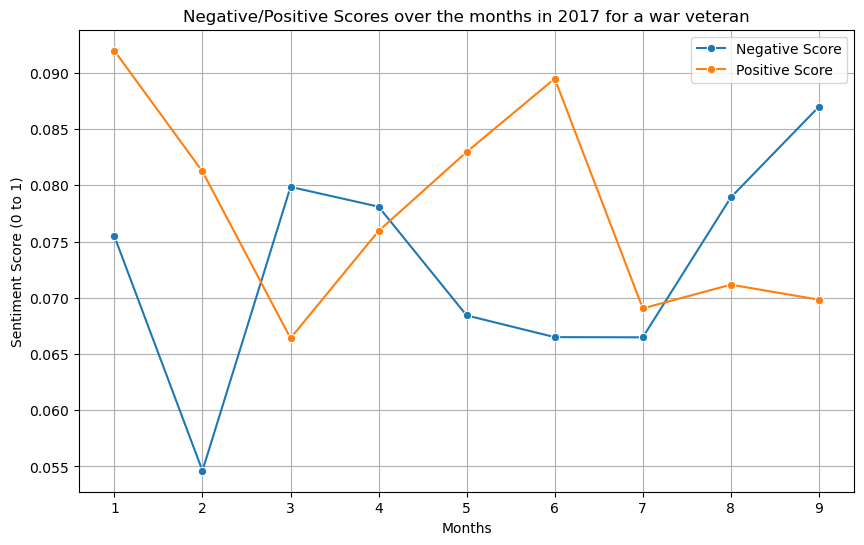

In [22]:
# plotting
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='month', y='negative', data=veteran_2017_avg, label='Negative Score', marker='o')
sns.lineplot(x='month', y='positive', data=veteran_2017_avg, label='Positive Score', marker='o')

plt.title('Negative/Positive Scores over the months in 2017 for a war veteran')
plt.xlabel('Months')
plt.ylabel('Sentiment Score (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

## Diary 60 & 61: Husband & Wife

Diary 60 contains dreams for Melora, who is the wife. Diary 61 contains dreams for Melvin, who is the husband.

- Diary 9 (highschool) diary 10 (college), follow Bea thru highschool and college 

### cleaning wife diaries

In [23]:
wife_df = pd.read_csv("data/diaries/diary60.csv", sep = "|")
wife_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#001 (06/19/62),"We were in a used car lot looking for a car, a...",0.081,0.879,0.040,-0.8228
1,1,#002 (06/19/62),This dream started out sort of confused. I was...,0.025,0.948,0.027,-0.0104
2,2,#003 (06/19/62),I was trying to be able to nurse my daughter a...,0.078,0.922,0.000,-0.6249
3,3,#004 (06/19/62),My husband and I seem to be driving down some ...,0.046,0.931,0.024,-0.8581
4,4,#005 (06/19/62),We got into my home in my hometown for some re...,0.013,0.916,0.071,0.8984


In [24]:
from datetime import datetime

# converting the 'raw_numbers' column into a column with just years
def conv_to_year60(raw_date):
    date_str = raw_date[6:-1]
    # convert to datetime format in 1900s
    date_datetime = datetime.strptime(date_str, "%m/%d/%y")
    year_1900 = date_datetime.year - 100
    date_datetime = date_datetime.replace(year=year_1900)
    return date_datetime

wife_df = wife_df.assign(date = wife_df['raw_number'].apply(conv_to_year60))
# checking unique values --> checks work
# unique_values = wife_df['date'].unique()
# print(unique_values)

# now after cleaning, replace empty spaces with NaN
wife_df.replace('', np.nan, inplace=True)
# remove rows with NaN values
wife_df = wife_df.dropna()
wife_df

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,date
0,0,#001 (06/19/62),"We were in a used car lot looking for a car, a...",0.081,0.879,0.040,-0.8228,1962-06-19
1,1,#002 (06/19/62),This dream started out sort of confused. I was...,0.025,0.948,0.027,-0.0104,1962-06-19
2,2,#003 (06/19/62),I was trying to be able to nurse my daughter a...,0.078,0.922,0.000,-0.6249,1962-06-19
3,3,#004 (06/19/62),My husband and I seem to be driving down some ...,0.046,0.931,0.024,-0.8581,1962-06-19
4,4,#005 (06/19/62),We got into my home in my hometown for some re...,0.013,0.916,0.071,0.8984,1962-06-19
...,...,...,...,...,...,...,...,...
204,204,#207 (09/02/64),The dream started with my meeting someone with...,0.102,0.852,0.046,-0.9853,1964-09-02
205,205,#208 (09/24/65),I was trying to escape with my brother from ou...,0.000,0.960,0.040,0.1779,1965-09-24
206,206,#209 (09/24/65),"I was taking an exam, sort of high-schoolish. ...",0.051,0.886,0.063,0.3291,1965-09-24
207,207,#210 (09/24/65),"There was a virulent new religion, very dogmat...",0.035,0.949,0.016,-0.2574,1965-09-24


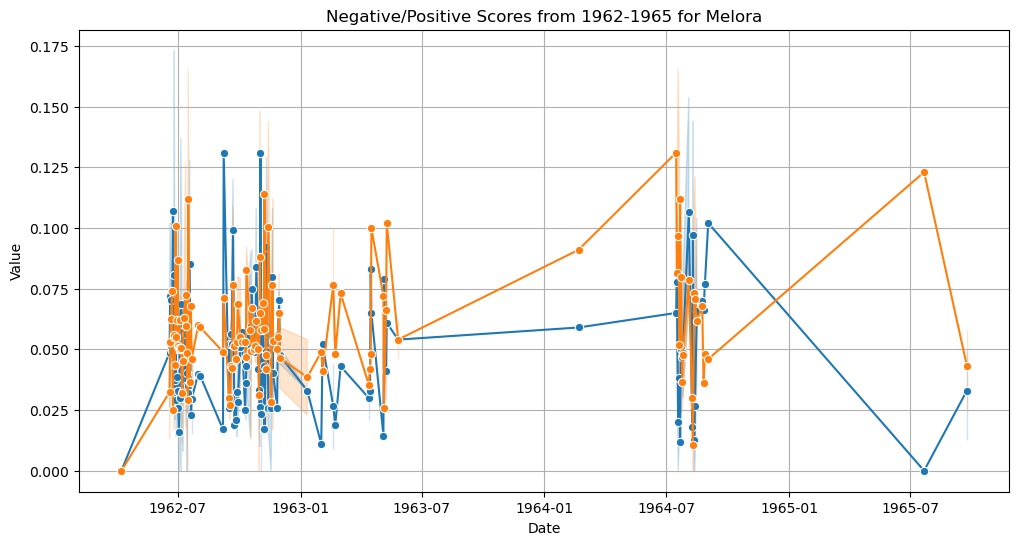

In [25]:
# Seaborn plotting
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(x='date', y='negative', data=wife_df, marker='o')
sns.lineplot(x='date', y='positive', data=wife_df, marker='o')

# Customize plot labels and title
plt.title('Negative/Positive Scores from 1962-1965 for Melora')
plt.xlabel('Date')
plt.ylabel('Value')

# Set x-axis limits to zoom into a specific period
# plt.xlim(pd.Timestamp('1962-07-01'), pd.Timestamp('1963-01-01'))
# plt.xlim(pd.Timestamp('1964-07-01'), pd.Timestamp('1965-01-01'))

# Display the plot
plt.grid(True)
plt.show()

### cleaning husband diaries

In [51]:
husband_df = pd.read_csv("data/diaries/diary61.csv", sep = "|")
husband_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#001 (06/18/62),I was in the basement of another man's house. ...,0.065,0.873,0.062,-0.1880
1,1,#002 (06/18/62),I was in my hometown with my mother and my wif...,0.113,0.856,0.032,-0.9454
2,2,#003 (06/18/62),"It concerned itself with my selling my car, wh...",0.018,0.891,0.091,0.8176
3,3,#004 (06/19/62),"I don't recall any clear episode, but there's ...",0.044,0.910,0.046,0.1318
4,4,#005 (06/19/62),I was standing on top of a cliff looking over ...,0.049,0.893,0.059,-0.0240


In [57]:
# converting the 'raw_numbers' column into a column with just years
def conv_to_year61(raw_date):
    date_str = raw_date[6:-1]

    # convert to datetime format in 1900s
    date_datetime = datetime.strptime(date_str, "%m/%d/%y")
    year_1900 = date_datetime.year - 100
    date_datetime = date_datetime.replace(year=year_1900)

    if date_datetime.year < 1950:
        return ''
    return date_datetime

husband_df = husband_df.assign(date = husband_df['raw_number'].apply(conv_to_year61))
# checking unique values --> checks work
# unique_values = wife_df['date'].unique()
# print(unique_values)

# now after cleaning, replace empty spaces with NaN
husband_df.replace('', np.nan, inplace=True)
# remove rows with NaN values
husband_df = husband_df.dropna()
husband_df

/var/folders/m4/bgf4hzvx2z9ftfdc9v3p51gw0000gn/T/ipykernel_64746/3736200602.py:14: FutureWarning: Inferring datetime64[ns] from data containing strings is deprecated and will be removed in a future version. To retain the old behavior explicitly pass Series(data, dtype={value.dtype})
  husband_df = husband_df.assign(date = husband_df['raw_number'].apply(conv_to_year61))


,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,date
0,0,#001 (06/18/62),I was in the basement of another man's house. ...,0.065,0.873,0.062,-0.1880,1962-06-18
1,1,#002 (06/18/62),I was in my hometown with my mother and my wif...,0.113,0.856,0.032,-0.9454,1962-06-18
2,2,#003 (06/18/62),"It concerned itself with my selling my car, wh...",0.018,0.891,0.091,0.8176,1962-06-18
3,3,#004 (06/19/62),"I don't recall any clear episode, but there's ...",0.044,0.910,0.046,0.1318,1962-06-19
4,4,#005 (06/19/62),I was standing on top of a cliff looking over ...,0.049,0.893,0.059,-0.0240,1962-06-19
...,...,...,...,...,...,...,...,...
123,123,#124 (01/02/65),"I was being chased by three vampires, the chie...",0.052,0.858,0.089,0.9811,1965-01-02
124,124,#125 (01/03/65),I and some friends were in an old deserted chu...,0.085,0.835,0.080,-0.4534,1965-01-03
125,125,#126 (01/20/65),"A Psychic Dream. On waking this morning, I rem...",0.021,0.911,0.068,0.9020,1965-01-20
126,126,#127 (02/04/65),"Since this concerns my grandfather, and the la...",0.079,0.884,0.037,-0.9747,1965-02-04


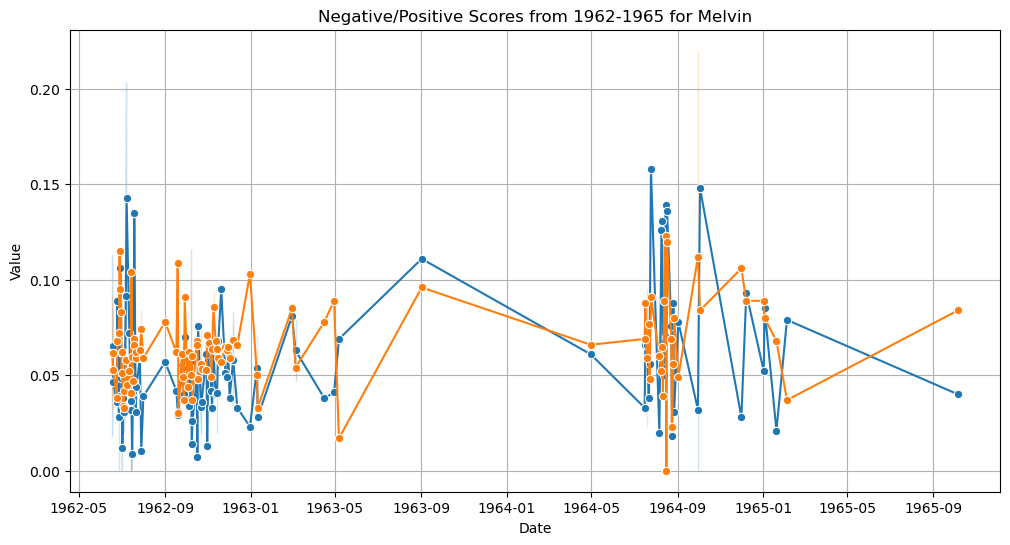

In [58]:
# Seaborn plotting
plt.figure(figsize=(12, 6))  # Adjust the figure size as needed
sns.lineplot(x='date', y='negative', data=husband_df, marker='o')
sns.lineplot(x='date', y='positive', data=husband_df, marker='o')

# Customize plot labels and title
plt.title('Negative/Positive Scores from 1962-1965 for Melvin')
plt.xlabel('Date')
plt.ylabel('Value')

# Set x-axis limits to zoom into a specific period
# plt.xlim(pd.Timestamp('1962-07-01'), pd.Timestamp('1965-01-01'))
# plt.xlim(pd.Timestamp('1964-07-01'), pd.Timestamp('1965-01-01'))

# Display the plot
plt.grid(True)
plt.show()

### diary 9 & 10: Bea thru highschool and college

In [63]:
highschool_df = pd.read_csv("data/diaries/diary09.csv", sep = "|")
highschool_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#001 (07/07/2003 (age 14)),I am on a trip to Italy with a lot of my frien...,0.080,0.860,0.060,-0.5947
1,1,#002 (07/08/2003 (age 14)),I'm in this elevator with Nick and Aidan. We a...,0.057,0.898,0.045,-0.5921
2,2,#003 (07/09/2003 (age 14)),I dreamed that there was this war happening an...,0.160,0.801,0.039,-0.9828
3,3,#004 (07/10/2003 (age 14)),I dreamed that I was on this train. In each di...,0.102,0.843,0.055,-0.9771
4,4,#005 (07/11/2003 (age 14)),So I dreamed that it was May again and everyon...,0.061,0.909,0.031,-0.9600


In [66]:
# converting the 'raw_numbers' column into a column with just years
def conv_to_year9(raw_date):
    date_str = raw_date[6:16]

    # convert to datetime format in 1900s
    # date_datetime = datetime.strptime(date_str, "%m/%d/%y")
    # year_1900 = date_datetime.year - 100
    # date_datetime = date_datetime.replace(year=year_1900)

    # if date_datetime.year < 1950:
    #     return ''
    return date_str #date_datetime

highschool_df = highschool_df.assign(date = highschool_df['raw_number'].apply(conv_to_year9))
# checking unique values --> checks work
unique_values = highschool_df['date'].unique()
print(unique_values)

# now after cleaning, replace empty spaces with NaN
# highschool_df.replace('', np.nan, inplace=True)
# # remove rows with NaN values
# highschool_df = highschool_df.dropna()
# highschool_df

ValueError: unconverted data remains: 03

In [61]:
diary10_df = pd.read_csv("data/diaries/diary10.csv", sep = "|")
diary10_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#001 (01/21/2007),Last night I dreamed that I was back at school...,0.084,0.916,0.000,-0.8201
1,1,#002 (04/06/2007),Last night I dreamed that I was in the gym and...,0.085,0.862,0.054,-0.4162
2,2,#003 (05/26/2007),I had a dream that I was at the Caan dining ha...,0.038,0.867,0.094,0.5423
3,3,#004 (05/27/2007),I had a dream that I was a senior at my high s...,0.016,0.925,0.059,0.6369
4,4,#005 (05/30/2007),Last night I dreamed I was holding Fluffy and ...,0.000,0.917,0.083,0.8885


### diary 20 analysis

why diary 20? it's because it's the diary with the most entries, with 6100 entries

In [26]:
# importing diary20
diary20_df = pd.read_csv("data/diaries/diary20.csv", sep = "|")
diary20_df.head()

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound
0,0,#0001 (1949-01-19 - Göttingen),Abschrift aus den Tagebuch vom 13.2.1947: Eine...,0.136,0.864,0.0,-0.9485
1,1,#0002 (1949-01-20 - Göttingen),"Ich bin in der russischen Zone, in Schwerin (u...",0.039,0.961,0.0,-0.8316
2,2,#0003 (1949-01-20 - Göttingen),Ich träumte dann noch irgend etwas Turbulentes...,0.053,0.947,0.0,-0.9136
3,3,#0004 (1949-01-20 - Göttingen),"Dann träumte ich weiter (es kann sein, dass di...",0.161,0.839,0.0,-0.9485
4,4,#0005 (1949-01-20 - Göttingen),Letzter Traum heute Nacht: Ich war im Schuhges...,0.245,0.755,0.0,-0.9892


In [27]:
# converting the 'raw_numbers' column into a column with just years
def conv_to_year20(raw_years):
    year = raw_years[7:11]

    if '.' in year:
        # raw_number format is #4614 (12.8.l997 - Zürich)' '1998'
        # taking care of edge cases
        if '#4614 (12.8.l997 - Zürich)' == raw_years:
            return 1997
        if '#5415 (27.10,199 - Zürich)' == raw_years:
            return 1990
        if '#5460 (17.1.2.1999 - Zürich)' == raw_years:
            return 1999
        if '#5133 (26.12.1998. - Zürich)' == raw_years:
            return 1998
        return raw_years
    if '0' == year[0]:
        # edge cases
        if '#4460 (0197-04-04, 04:30 - Berlin)' == raw_years:
            return 1970
        if '#5398 (0199-10-11, 13:45 - Zürich)' == raw_years:
            return 1990
        if '#5431 (0199-11-16, 03:00 - Zürich)' == raw_years:
            return 1990
        if '#5522 (0200-02-10, 05:45 - Freiburg)' == raw_years:
            return 2000
        return raw_years
    else:
        return int(year) 

diary20_df = diary20_df.assign(year = diary20_df['raw_number'].apply(conv_to_year20))
# removing false years (i.e. 2952, 1052)
diary20_df = diary20_df.assign(year = diary20_df['year'].apply(lambda year: year if (year <= 2024) & (year >= 1700) else ''))
# checking unique values --> checks work
# unique_values = diary20_df['year'].unique()
# print(unique_values)

# now after cleaning, replace empty spaces with NaN
diary20_df.replace('', np.nan, inplace=True)
# remove rows with NaN values
diary20_df = diary20_df.dropna()
diary20_df

,Unnamed: 0,raw_number,content,negative,neutral,positive,compound,year
0,0,#0001 (1949-01-19 - Göttingen),Abschrift aus den Tagebuch vom 13.2.1947: Eine...,0.136,0.864,0.000,-0.9485,1949.0
1,1,#0002 (1949-01-20 - Göttingen),"Ich bin in der russischen Zone, in Schwerin (u...",0.039,0.961,0.000,-0.8316,1949.0
2,2,#0003 (1949-01-20 - Göttingen),Ich träumte dann noch irgend etwas Turbulentes...,0.053,0.947,0.000,-0.9136,1949.0
3,3,#0004 (1949-01-20 - Göttingen),"Dann träumte ich weiter (es kann sein, dass di...",0.161,0.839,0.000,-0.9485,1949.0
4,4,#0005 (1949-01-20 - Göttingen),Letzter Traum heute Nacht: Ich war im Schuhges...,0.245,0.755,0.000,-0.9892,1949.0
...,...,...,...,...,...,...,...,...
6089,6089,"#6096 (2001-12-03, 23:45 - Zürich)","Zwei Männer, die in einem gesunkenen Schiff in...",0.126,0.874,0.000,-0.8316,2001.0
6090,6090,"#6097 (2001-12-03, 06:30 - Zürich)",Wohnen in einer gemütlich eingerichteten Höhle...,0.000,1.000,0.000,0.0000,2001.0
6091,6091,"#6098 (2001-12-04, 04:45 - Zürich)",Ein Faschingsfest. Bille und Tina und Belli ha...,0.206,0.794,0.000,-0.9761,2001.0
6092,6092,"#6099 (2001-12-06, 02:45 - Zürich)","Ging mit Emme durch eine Strasse, die ganz der...",0.146,0.842,0.012,-0.9896,2001.0


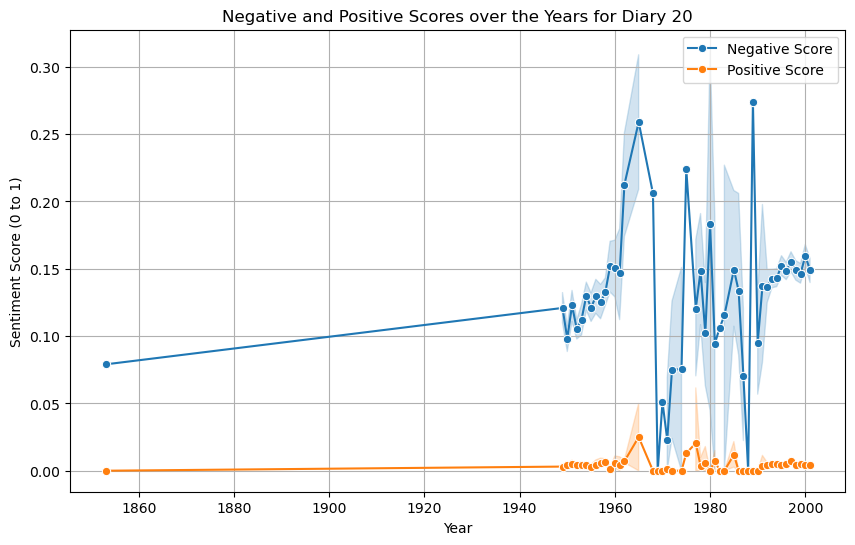

In [28]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='year', y='negative', data=diary20_df, label='Negative Score', marker='o')
sns.lineplot(x='year', y='positive', data=diary20_df, label='Positive Score', marker='o')

plt.title('Negative and Positive Scores over the Years for Diary 20')
plt.xlabel('Year')
plt.ylabel('Sentiment Score (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

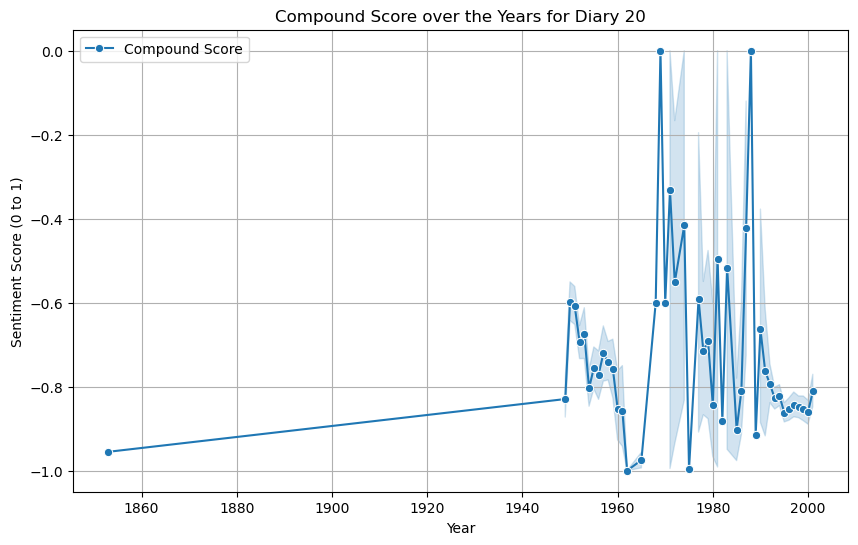

In [29]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='year', y='compound', data=diary20_df, label='Compound Score', marker='o')

plt.title('Compound Score over the Years for Diary 20')
plt.xlabel('Year')
plt.ylabel('Sentiment Score (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

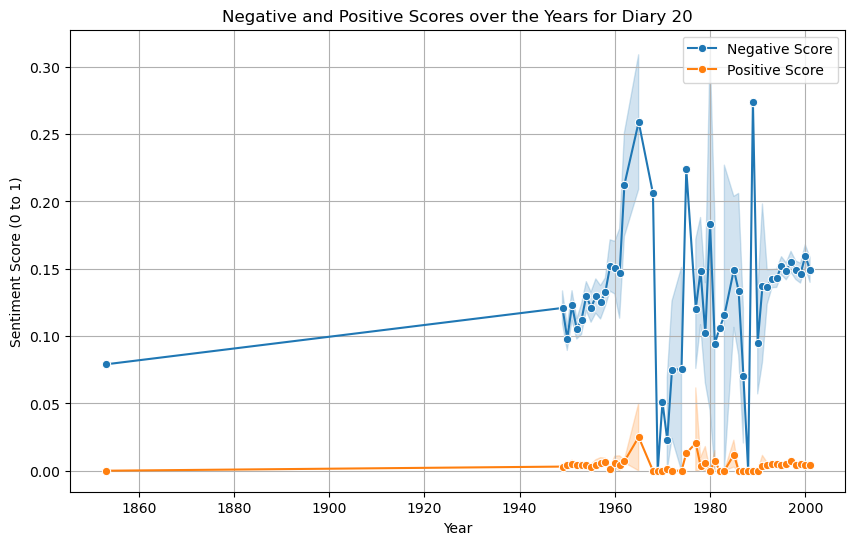

In [30]:
plt.figure(figsize=(10, 6))  # Adjust the figure size as needed
sns.lineplot(x='year', y='negative', data=diary20_df, label='Negative Score', marker='o')
sns.lineplot(x='year', y='positive', data=diary20_df, label='Positive Score', marker='o')

plt.title('Negative and Positive Scores over the Years for Diary 20')
plt.xlabel('Year')
plt.ylabel('Sentiment Score (0 to 1)')
plt.legend()
plt.grid(True)
plt.show()

In [35]:
pos_summary = pd.read_csv("data/positive_summary.csv")
pos_summary.head()

,diary,count,mean,std,min,25%,50%,75%,max
0,1,422.0,0.078336,0.035076,0.0,0.0550,0.0750,0.09800,0.272
1,2,48.0,0.071042,0.035468,0.0,0.0485,0.0720,0.08925,0.146
2,3,212.0,0.057104,0.045721,0.0,0.0220,0.0500,0.08425,0.216
3,4,3114.0,0.097733,0.071887,0.0,0.0550,0.0870,0.12900,1.000
4,5,1138.0,0.098941,0.064120,0.0,0.0550,0.0875,0.13400,0.448


In [41]:
pos_summary['mean'].mean()

0.06974051302192463

In [36]:
neg_summary = pd.read_csv("data/negative_summary.csv")
neg_summary.head()

,diary,count,mean,std,min,25%,50%,75%,max
0,1,422.0,0.051294,0.031847,0.0,0.03100,0.0460,0.06675,0.264
1,2,48.0,0.053437,0.028005,0.0,0.03175,0.0515,0.07925,0.114
2,3,212.0,0.065892,0.054758,0.0,0.02900,0.0580,0.09500,0.269
3,4,3114.0,0.070487,0.065115,0.0,0.03100,0.0580,0.09300,0.737
4,5,1138.0,0.069237,0.061152,0.0,0.02900,0.0560,0.09375,0.608


In [42]:
neg_summary['mean'].mean()

0.059064870878309965

- diary 92, vietname vet
- diary 60 (wife) and 61 (husband)
- diary 9 (highschool) diary 10 (college), follow Bea thru highschool and college 